In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm_notebook
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

In [2]:
import seaborn as sns

In [499]:
%autosave 60

Autosaving every 60 seconds


In [2]:
column_names = pd.read_csv('column_names.txt').columns

    Periods of time when sock is not being used and it was not fully charged => degraded battery

    How many hours has the device been used (define being used..base > 6?) at any given time?

    How long since the first use of the device at any given time?

        What other factors are pertinant? *what percent it was at b4 monitoring, how many times the device died etc*

    What percent of Battery lost per hour (should never be > 12.5 or the sock won't last 8 hours)

    EXTRA: What time of day are batteries dying? How many stop monitoring because the battery died?
    
***

Inclusion: V2 device, hasn't been stored with battery < 95% ? for long time..how much time, 

In [3]:
def clean_df(df):
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.sort_values(by=['timestamp'])
    df.drop_duplicates('timestamp',inplace=True)

    df = df.loc[(df.ble_rssi != 0)] # do i care about this for battery level? HR > 0??
    df.reset_index(inplace=True, drop=True)
    return df

# FIRST need to tell if a device was ever stored for some time with the battery not fully charged
# find gaps > 48 hours or something.. (gaps where base state is not even 3) 
    # what was the battery level just before the gap?

def find_battery_before_gaps(df, gap_size):
    # dont include last data point 
    # change fillna..
    gaps = df.timestamp.diff(-1).fillna(gap_size-pd.Timedelta(days=1)).abs().ge(gap_size)
    day_before = df[gaps]
    return list(day_before.battery_level)

    
def degraded_battery_using_df(df, gap_size, thresh=95):
    '''If return True: the device should be removed from study'''
    
    # Problems for ayla outage (looks like gap but we actually don't know what happened those days..)    
    # Find battery level before long gaps.. 
    df_battery_before_gaps = find_battery_before_gaps(df, gap_size)
    # If any of those are < 95 (or some thresh) return false
    if any(np.array(df_battery_before_gaps) < thresh):
        return True
    else:
        return False

def degraded_battery_16k(dsn, gap_size, folder_dsns, thresh=95):
    #TODO get rid of 20160101
    folder_2sec = find_folder(dsn, folder_dsns)
    filepaths = glob(f'/Volumes/baileyWD/TwoSecondSockMask{folder_2sec}/{dsn}/*.csv.gz')
    all_dates = sorted([date(int(day[-15:-11]), int(day[-11:-9]), int(day[-9:-7])) for day in filepaths])
    # turn into series? or can i do diff
    diff = np.diff(all_dates) # Take into account gaps that naturally exist like Feb 2019 - Apr 2019..
    gap_mask = np.append((diff >= gap_size),np.array(False))
    
    days_before_large_gap = list(np.array(all_dates)[gap_mask])
    print(days_before_large_gap)
    if len(days_before_large_gap) == 0:
        return False
    else:
        # load 2 second data for days_before_large_gap and check last battery level
        for day in days_before_large_gap:
            print(day)
            day = str(day).replace('-', '')
            if day != '20160101':
                df = pd.read_csv(f'/Volumes/baileyWD/TwoSecondSockMask{folder_2sec}/{dsn}/{dsn}_{day}.csv.gz', compression='gzip', names=column_names)
                df = clean_df(df)
                if df.shape[0] != 0:
                    # what is the battery level for the last reading\
                    battery_level = df[df.timestamp == df.timestamp.max()].battery_level.values[0]
                    print(battery_level)
                    if battery_level < thresh:
                        # Try counting instead of returning True
                        return True
    
    return False

def count_degraded_battery(dsn, gap_size, folder_dsns, thresh=95):
    count = 0
    folder_2sec = find_folder(dsn, folder_dsns)
    filepaths = glob(f'/Volumes/baileyWD/TwoSecondSockMask{folder_2sec}/{dsn}/*.csv.gz')
    all_dates = sorted([date(int(day[-15:-11]), int(day[-11:-9]), int(day[-9:-7])) for day in filepaths])
    # turn into series? or can i do diff
    diff = np.diff(all_dates) # Take into account gaps that naturally exist like Feb 2019 - Apr 2019..
    gap_mask = np.append((diff >= gap_size),np.array(False))
    
    days_before_large_gap = list(np.array(all_dates)[gap_mask])
    
    if len(days_before_large_gap) == 0:
        return count
    else:
        # load 2 second data for days_before_large_gap and check last battery level
        for day in days_before_large_gap:
            day = str(day).replace('-', '')
            df = pd.read_csv(f'/Volumes/baileyWD/TwoSecondSockMask{folder_2sec}/{dsn}/{dsn}_{day}.csv.gz', compression='gzip', names=column_names)
            df = clean_df(df)
            if df.shape[0] != 0:
                # what is the battery level for the last reading\
                battery_level = df[df.timestamp == df.timestamp.max()].battery_level.values[0]
                if battery_level < thresh:
                    # Try counting instead of returning True
                    count += 1
    
    return count

def longest_consecutive(df, thresh=pd.Timedelta(minutes=1)):
    '''Get the data of the longest consecutive interval'''
    df['time_diff'] = df.timestamp.diff()
    times = sorted(list(set(list(df[df.time_diff > thresh].timestamp.values) + [list(df.timestamp.values)[-1]])))
    most_consec = 0
    best = pd.DataFrame()
    for i in range(len(times)):
        # when to not include times[i]
        if i == 0:
            df_consec = df[df.timestamp < times[i]]
            len_ = df_consec.shape[0]
        else:
            df_consec = df[(df.timestamp < times[i]) & (df.timestamp >= times[i-1])]
            len_ = df_consec.shape[0]

        if len_ > most_consec:
            most_consec = len_
            best = df_consec
            
    return best

def battery_lost_per_hr(time_passed, df_non_charging):
    '''idea: take an hour of monitoring data and see how the battery degrades
        or take a day and calculate the battery lost per hour (since the battery may not change much in 1 hr)'''
    
    if time_passed < 3600:
        return -1
    battery_diff = df_non_charging.battery_level.values[0] - df_non_charging.battery_level.values[-1]
    # return change in battery level / time (convert to change per hour)
    time_in_hrs = (time_passed/60)/60
    return battery_diff/time_in_hrs

#     df_non_charging['index_diff'] = df_non_charging['index'] - df_non_charging.index    
#     difference = df_non_charging.index_diff.value_counts().idxmax()
#     df_non_charging = df_non_charging.loc[df_non_charging.index_diff == difference]

def non_charging_time(df):
    '''How long was the longest monitoring session for the day, also return the data'''
    df_non_charging = df.loc[(df.base_state != 3) & (df.battery_level > 0) & (df.battery_level <= 100)][['timestamp','battery_level']].reset_index()


    if df_non_charging.shape[0] == 0:
        return 0, pd.DataFrame()

    df_non_charging = longest_consecutive(df_non_charging, thresh=pd.Timedelta(minutes=1)) # try 10 seconds

    if df_non_charging.shape[0] == 0:
        return 0, pd.DataFrame()
    # burn in
    df_non_charging = df_non_charging.iloc[450:] # 15 min TODO is this how much time i want to do?
    if df_non_charging.shape[0] == 0:
        return 0, pd.DataFrame()
    time_passed = (df_non_charging.iloc[-1].timestamp - df_non_charging.iloc[0].timestamp).seconds
    
    return time_passed, df_non_charging

def total_hours_of_use(df, day):
    '''10 min rollups'''
    # Sum count from entire rollup df = # of 2 second intervals monitored (base >= 4)
    # ((sum * 2) / 60) / 60 # should give hours
    df = df[df.index <= str(day)]
    seconds = df['count'].sum() * 2 # Total number of data points collected (represent 2 seconds)
    hours = (seconds/60)/60
    return hours

def load_2_sec(dsn, folder, day):
    day = str(day.date()).replace('-', '')
    filename = f'/Volumes/baileyWD/TwoSecondSockMask{folder}/{dsn}/{dsn}_{day}.csv.gz'
    df = pd.read_csv(filename, compression='gzip', names=column_names)
    df.drop_duplicates('timestamp')
    
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.sort_values(by=['timestamp'])
    df = df.reset_index(drop=True)
    return df

def find_folder(dsn, folder_dsns):
    for num in [9,10,11,12,13,14,15,16]:
        if dsn in folder_dsns[f'BinaryMask{num}']:
            return num

In [4]:
def time_charging(dsn, timestamp, folder):
    '''How much time was the base state 3 before use, 
    hard b/c it probably crosses over different days'''
    # Take in time from the df used to calculate battery loss
    # load that day
    day = str(timestamp.date()).replace('-','')
    df = pd.read_csv(f'/Volumes/baileyWD/TwoSecondSockMask{folder}/{dsn}/{dsn}_{day}.csv.gz', compression='gzip',names=column_names)
    
    try:
        # load maybe 1-2 days before IF they exist (combine into 1 sorted df)
        one = str((timestamp - pd.Timedelta(days=1)).date()).replace('-','')
        day_before = pd.read_csv(f'/Volumes/baileyWD/TwoSecondSockMask{folder}/{dsn}/{dsn}_{one}.csv.gz', compression='gzip',names=column_names)
        df = df.append(day_before)
        
        two = str((timestamp - pd.Timedelta(days=2)).date()).replace('-','')
        two_days_before = pd.read_csv(f'/Volumes/baileyWD/TwoSecondSockMask{folder}/{dsn}/{dsn}_{two}.csv.gz', compression='gzip',names=column_names)
        df = df.append(two_days_before)
    
    except:
        pass
    
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df_test.drop_duplicates('timestamp',inplace=True)
    df = df.sort_values(by='timestamp')
    
    # look at all data before the start of data used to calculate battery loss
    df = df.loc[df.timestamp < str(timestamp)]
    df = df.loc[df.base_state == 3]
    if df.shape[0] == 0:
        return pd.Timedelta(days=-1)
    # Check for the last consecutive base state 3 data, how long was it in base state 3 
    df['time_diff'] = df.timestamp.diff()
    times = sorted(list(set(list(df[df.time_diff > pd.Timedelta(minutes=1)].timestamp.values) + [list(df.timestamp.values)[-1]])))
    
    if len(times) > 1:
        #get ammount of time btw last 2 times
        df = df.loc[(df.timestamp <= times[-1]) & (df.timestamp > times[-2])]
    
    time = df.iloc[-1].timestamp - df.iloc[0].timestamp    
    return time


In [898]:
test_dsn = 'AC000W001147314'
test_folder = 15
test_timestamp = d.iloc[0].timestamp
time_charging(test_dsn, test_timestamp, test_folder)

Timedelta('1 days 12:49:20')

In [873]:
str(test_timestamp.date()).replace('-','')

'2018-01-02'

In [746]:
# degraded_battery('AC000W002425949', timedelta(days=3))

In [1363]:
degraded_battery_16k('AC000W001044895', timedelta(days=100), folder_dsns, thresh=90) 

[datetime.date(2016, 1, 1), datetime.date(2017, 5, 3)]
2016-01-01
2017-05-03
100


False

Not degraded for 16k round 2

In [29]:
# v2_devices = pickle.load(open('V2_monitoring_data/v2_devices.p','rb'))
# round_2 = pickle.load(open('16k_round_2/rollups_dsns.p','rb'))
# v2_round2 = round_2.intersection(v2_devices)
# folder_dsns = pickle.load(open('folder_dsns.p', 'rb'))
# analyzing_dsns = set(df_2.dsn.values)
# not_degraded = []
# # degraded_dsns = []
# for dsn in tqdm_notebook(analyzing_dsns):
#     degraded = degraded_battery_16k(dsn,timedelta(days=3),folder_dsns,thresh=90)
#     if not degraded:
#         not_degraded.append(dsn)
# #     degraded = degraded_battery_16k(dsn, timedelta(days=8), folder_dsns, thresh=80)
# #     if not degraded:
# #         not_degraded.append(dsn)

In [98]:
# pickle.dump(not_degraded, open('16k_round_2_not_degraded.p','wb'))

In [681]:
# not_degraded = pickle.load(open('16k_round_2_not_degraded.p','rb'))#[:6]

#### Idea: Just look at how much time the sock is used between charging - if it is >= 8 hours then that's good, if not would it have lasted?

In [6]:
def analysis(dsn, v2_updated_at, folder, folder_dsns):
    '''Check for how long the longest usage is each day'''
    rows = []    
    device_num = 1
#     dsn_reg = registration.loc[registration.dsn == dsn]
    
    for i in range(len(v2_updated_at)):
        became_v2 = v2_updated_at[i]
        # Get the 1st day of use (use to calculate how long since 1st use)
        ten_min = pickle.load(open(f'/Volumes/baileyWD/{folder}/16000_dfs/{dsn}_df.p', 'rb')).drop_duplicates()
        if (i == len(v2_updated_at) - 1):
            ten_min = ten_min.loc[ten_min.index >= str(became_v2)]
        else:
            ten_min = ten_min.loc[(ten_min.index >= str(became_v2)) & (ten_min.index < str(v2_updated_at[i+1]))]
#         if dsn_reg.shape[0] != 0:
#             # Get earliest registration day: take data only on/after that day
#             earliest_reg = dsn_reg.registered_at.min()[:10]
#             ten_min = ten_min.loc[ten_min.index >= earliest_reg]

        if ten_min.shape[0] > 0:
            folder_2sec = find_folder(dsn, folder_dsns)
            # days with non charging data, sample  every 30 (not worried about every single day)
            unique_days = list(ten_min.index.normalize().unique())
            df_days = list(set(unique_days[::4] + unique_days[-5:])) #  what days? 

            first_day = unique_days[0]

            for day in df_days:
                df_2sec = load_2_sec(dsn, folder_2sec, day)
                df_2sec = clean_df(df_2sec)
                time_since_first = day - first_day 
                usage = total_hours_of_use(ten_min, day)
                time_passed, df_non_charging = non_charging_time(df_2sec)
#                 if df_non_charging.shape[0] != 0:
#                     charging_time = time_charging(dsn, df_non_charging.iloc[0].timestamp, folder_2sec)
#                 else:
#                     charging_time = pd.Timedelta(days=-1)

                battery_degredation = battery_lost_per_hr(time_passed, df_non_charging)
                if time_passed > 28800: 
                    lost_per_hour = 'pass'
                    rows.append((dsn+f'_{device_num}', day.date(), time_since_first, usage, lost_per_hour, battery_degredation,device_num))
                else:

                    if battery_degredation > -1 and battery_degredation < 12.5:
                        lost_per_hour = 'pass'
                    else:
                        lost_per_hour = 'fail'

                    if battery_degredation != -1:
                        rows.append((dsn+f'_{device_num}', day.date(), time_since_first, usage, lost_per_hour, battery_degredation,device_num))
        device_num += 1
    
    return rows

def battery_analysis(dsn_list, v2_info):
    rows = []
    folder = '16k_round_2'
    folder_dsns = pickle.load(open('folder_dsns.p', 'rb'))
    for dsn in tqdm_notebook(dsn_list):
        devices = v2_info.loc[v2_info.dsn==dsn].updated_at.values
        rows += analysis(dsn, devices, folder, folder_dsns)
            
    df_columns = ['dsn', 'date','time_since_first_use','hours_of_use','lasts_8_hrs','battery_lost_per_hr','sock_number']
    full_df = pd.DataFrame(rows, columns=df_columns)
    return full_df

In [10]:
def datetime_to_date(x):
    return date(int(x[:4]),int(x[5:7]),int(x[8:10]))

In [11]:
# registration = pd.read_csv('/Users/brodriguez/Documents/parsed_registration_pre_20190113.csv', compression='gzip', index_col=0)
# registration = registration[registration.ayla_uuid != '0']

# v2_updated_at = pd.read_csv('csv_df_10/v2_updated_at.csv', compression='gzip')
# v2_updated_at.query('dsn in @ round_2',inplace=True)

v2_info = pd.read_csv('csv_df_10/v2_info.csv', compression='gzip')
v2_info.query("val_string == 'V2'",inplace=True)
v2_info = v2_info[['dsn','updated_at']].sort_values(by=['dsn','updated_at'])
# change updated at to just be the date then drop duplicate dsn/date combo
v2_info.updated_at = v2_info.updated_at.apply(datetime_to_date)
v2_info = v2_info.drop_duplicates()

In [7]:
dsns_16k = pickle.load(open('16k_round_2/rollups_dsns.p','rb'))

In [8]:
len(dsns_16k)

15992

In [13]:
v2_dsns = dsns_16k.intersection(v2_info.dsn.unique().tolist())

In [14]:
len(v2_dsns)

11427

In [15]:
15992 - 11427

4565

In [29]:
len(v2_dsns.intersection(df_2_dsns))

10893

In [30]:
11427-10893

534

In [32]:
len(df_2[df_2.time_since_first_use >= pd.Timedelta(days=365)].dsn.unique().tolist())

1153

In [44]:
df_2[(df_2.time_since_first_use >= pd.Timedelta(days=365)) & (df_2.hours_of_use < 1500)].dsn.value_counts()#.hours_of_use.min()

AC000W000258132_1    40
AC000W001102880_1    36
AC000W000504234_1    34
AC000W001044297_1    33
AC000W001133451_1    32
AC000W001044076_1    31
AC000W001123267_1    31
AC000W001183558_1    29
AC000W001042326_1    29
AC000W001053234_1    29
AC000W001125779_1    28
AC000W001111362_1    28
AC000W001059208_1    28
AC000W001081571_1    27
AC000W001059479_1    26
AC000W001107617_1    26
AC000W001135571_1    26
AC000W001082203_1    26
AC000W001082733_1    25
AC000W001041773_1    25
AC000W001042700_1    25
AC000W001155229_1    25
AC000W001085883_1    23
AC000W000326259_1    23
AC000W000460838_1    23
AC000W000504417_1    22
AC000W001046603_1    22
AC000W001085733_1    22
AC000W001041436_1    21
AC000W001064690_1    20
                     ..
AC000W000326135_1     2
AC000W001125801_1     2
AC000W001074261_1     2
AC000W001041131_1     2
AC000W001100025_1     1
AC000W001042738_1     1
AC000W001112309_1     1
AC000W001065975_1     1
AC000W001202872_1     1
AC000W000504863_1     1
AC000W001137670_

In [47]:
hours_per_day = df_2.hours_of_use / df_2.time_since_first_use.apply(lambda x: x.days) 

In [79]:
normal_use = df_2[hours_per_day > 4]#.dsn.value_counts()

In [80]:
normal_use.dsn.value_counts()#[normal_use.time_since_first_use >= pd.Timedelta(days=365)].dsn.value_counts()

AC000W001179845_1    157
AC000W001047709_1    148
AC000W001183363_1    147
AC000W001126097_1    145
AC000W001132025_1    144
AC000W001125217_1    143
AC000W001132867_1    141
AC000W000333758_1    141
AC000W001087120_1    140
AC000W001057502_1    140
AC000W001127635_1    140
AC000W001060797_1    139
AC000W001053748_1    139
AC000W001094005_1    137
AC000W001101576_1    137
AC000W001056492_1    136
AC000W001183464_1    136
AC000W001137930_1    135
AC000W001088745_1    135
AC000W001098107_1    135
AC000W001057098_1    134
AC000W001095723_1    133
AC000W001057664_1    130
AC000W001046768_1    130
AC000W001089395_1    128
AC000W000444697_1    128
AC000W001057623_1    127
AC000W001094991_1    127
AC000W001183387_1    127
AC000W001064397_1    127
                    ... 
AC000W002600605_1      1
AC000W003379508_1      1
AC000W001205487_2      1
AC000W001153751_1      1
AC000W001056279_1      1
AC000W001054232_1      1
AC000W002438322_1      1
AC000W003417725_1      1
AC000W002625489_1      1


In [56]:
normal_use_dsns = normal_use.dsn.unique().tolist()

In [75]:
normal_use[normal_use.lasts_8_hrs == 'fail'].dsn.value_counts()

AC000W001181968_1    12
AC000W001044895_1     9
AC000W001059508_1     8
AC000W001132290_1     6
AC000W001097928_1     5
AC000W000448598_1     5
AC000W001132523_1     4
AC000W002581489_1     4
AC000W001053548_1     4
AC000W001097448_1     3
AC000W002424261_1     3
AC000W001052980_1     3
AC000W001117688_1     3
AC000W001144086_1     3
AC000W001041763_1     3
AC000W001117554_1     3
AC000W001052430_1     3
AC000W001108779_1     3
AC000W001199263_1     3
AC000W001204586_1     3
AC000W001145390_1     3
AC000W001108769_1     3
AC000W000503671_1     3
AC000W001115464_1     3
AC000W001123356_1     3
AC000W001127369_1     3
AC000W001147691_1     3
AC000W001143013_1     3
AC000W001099187_2     3
AC000W001127606_1     2
                     ..
AC000W001104560_1     1
AC000W001140471_1     1
AC000W002585981_1     1
AC000W001071505_1     1
AC000W001044056_1     1
AC000W001153542_1     1
AC000W001144127_1     1
AC000W001086596_1     1
AC000W001096063_1     1
AC000W001125498_1     1
AC000W001058506_

In [ ]:
# df_2_dsns = [d[:-2] for d in df_2.dsn.unique().tolist()]

In [928]:
# df_3 = battery_analysis(list(v2_round2)[:5713], v2_updated_at) #use v2_round2 
#no sampling over the weekend?

In [494]:
# test_charging2 = battery_analysis(['AC000W001181968'], v2_updated_at)

In [493]:
# test_charging2.sort_values(by='date')

In [497]:
v2_round2_list = pickle.load(open('v2_round2_list.p','rb'))

In [3]:
# df_2 = battery_analysis(v2_round2_list[:5713], v2_info)
df_2 = pickle.load(open('new_first_half_df_2.p', 'rb'))

In [ ]:
# df_2nd_half = battery_analysis(v2_round2_list[5713:], v2_info)#do this in separate notebook to speed up

In [677]:
# pickle.dump(df_2,open('first_half_df_2.p','wb'))
# pickle.dump(df_2,open('new_first_half_df_2.p','wb'))

In [679]:
df_2[df_2.battery_lost_per_hr < 0] # check on these
# 1st: few seconds of charging before being used again and then charged right after
# 2nd: case that needs to be thrown out, goes from 3% battery to 98% battery with no gap in time..not possible
# 3rd: same as 1st

,dsn,date,time_since_first_use,hours_of_use,lasts_8_hrs,battery_lost_per_hr,sock_number
22397,AC000W001130929_1,2017-06-23,24 days,311.105000,pass,-0.838379,1
22770,AC000W001107475_2,2017-12-13,0 days,0.165556,pass,-0.410917,2
128409,AC000W001213248_1,2018-12-15,189 days,1399.459444,pass,-0.445545,1


In [4]:
df_2nd_half = pickle.load(open('new_second_half_df_2.p','rb'))
df_2 = df_2.append(df_2nd_half, ignore_index=True)

In [5]:
df_2 = df_2.drop_duplicates()

In [11]:
df_2[df_2.dsn == 'AC000W002637347_1']

,dsn,date,time_since_first_use,hours_of_use,lasts_8_hrs,battery_lost_per_hr,sock_number
252156,AC000W002637347_1,2018-09-30,24 days,134.772778,pass,5.391658,1
252157,AC000W002637347_1,2018-10-07,31 days,194.540556,pass,3.487282,1
252158,AC000W002637347_1,2018-10-04,28 days,144.737222,pass,3.191666,1
252159,AC000W002637347_1,2018-10-06,30 days,176.226667,pass,3.705752,1
252160,AC000W002637347_1,2018-09-14,8 days,41.745556,pass,3.345725,1
252161,AC000W002637347_1,2018-09-21,15 days,72.877778,pass,3.282758,1
252162,AC000W002637347_1,2018-09-06,0 days,0.000000,pass,4.540295,1
252163,AC000W002637347_1,2018-10-05,29 days,166.170000,pass,2.286156,1


In [22]:
df_2 = df_2.loc[df_2.sock_number < 3] # Just look at first 2 reported V2 devivces per dsn

In [23]:
df_2 = df_2.loc[df_2.battery_lost_per_hr > 0] # Ignore weird cases (only a few)

In [59]:
# fail_dsns = list(df_2[(df_2.lasts_8_hrs == 'fail') ].dsn.value_counts().index.values)
fail_dsns = normal_use[normal_use.lasts_8_hrs == 'fail'].dsn.unique().tolist()

In [797]:
i=58

In [883]:
i+=1

In [884]:
df_2[(df_2.dsn == fail_dsns[i])].sort_values(by='date')

,dsn,date,time_since_first_use,hours_of_use,lasts_8_hrs,battery_lost_per_hr,sock_number
264984,AC000W000231724_1,2017-10-09,4 days,37.803889,pass,3.868665,1
265023,AC000W000231724_1,2017-10-13,8 days,88.553333,pass,4.085222,1
265001,AC000W000231724_1,2017-10-17,12 days,134.367222,pass,3.738965,1
265040,AC000W000231724_1,2017-10-21,16 days,186.573333,pass,4.148028,1
265018,AC000W000231724_1,2017-10-25,20 days,237.596667,pass,3.456083,1
265055,AC000W000231724_1,2017-10-29,24 days,292.615000,pass,4.038661,1
265033,AC000W000231724_1,2017-11-02,28 days,346.672222,pass,3.863641,1
265068,AC000W000231724_1,2017-11-06,32 days,399.011111,pass,3.944312,1
265003,AC000W000231724_1,2017-11-10,36 days,460.520556,pass,3.989844,1
265059,AC000W000231724_1,2017-11-15,41 days,508.520556,pass,3.926321,1


In [885]:
i

101

In [57]:
fail_to_keep = ['AC000W001181968_1',
'AC000W001044895_1',
'AC000W001059508_1',
'AC000W001132290_1',
'AC000W001183787_2',
'AC000W001097928_1',
'AC000W001099490_1',
'AC000W000448598_1',
'AC000W002581489_1',
'AC000W001144086_1',
'AC000W001143013_1',
'AC000W001145390_1',
'AC000W001111459_1',
'AC000W002628776_1']

In [58]:
set(fail_to_keep).intersection(normal_use_dsns)

{'AC000W000448598_1',
 'AC000W001044895_1',
 'AC000W001059508_1',
 'AC000W001097928_1',
 'AC000W001111459_1',
 'AC000W001132290_1',
 'AC000W001143013_1',
 'AC000W001144086_1',
 'AC000W001145390_1',
 'AC000W001181968_1',
 'AC000W002581489_1',
 'AC000W002628776_1'}

In [60]:
fail_instant2 = set(fail_dsns) - set(fail_to_keep)

In [61]:
len()

608

In [206]:
d = ['AC000W001181968',
'AC000W001044895',
'AC000W001134458',
'AC000W001113324',
'AC000W001132290',
'AC000W001097928',
'AC000W001129995',
'AC000W001099490',
'AC000W001180881',
'AC000W001143365',
'AC000W001198836']
fail_instant = set(df_2[df_2.lasts_8_hrs == 'fail'].dsn.unique().tolist()) - set(d)

In [1671]:
# pickle.dump(df_2,open('df_2_jul18.p','wb'))
# df_2 = pickle.load(open('df_2_jul18.p','rb'))

## A look at battery level, what is normal?

In [981]:
# df_test = pd.read_csv('/Users/brodriguez/Documents/Owlet-code/16k_round_2/16000_2sec/20181218/AC000W003383419.csv.gz', compression='gzip',names=column_names)
# /Volumes/baileyWD/TwoSecondSockMask10/AC000W000104360/AC000W000104360_20180626.csv.gz
df_test = pd.read_csv('/Volumes/baileyWD/TwoSecondSockMask12/AC000W001213248/AC000W001213248_20181215.csv.gz', compression='gzip',names=column_names)
df_test.timestamp = pd.to_datetime(df_test.timestamp, unit='s')
df_test = df_test.sort_values(by=['timestamp'])
df_test.drop_duplicates('timestamp',inplace=True)

df_test = df_test.loc[(df_test.ble_rssi != 0)]

df_test.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>


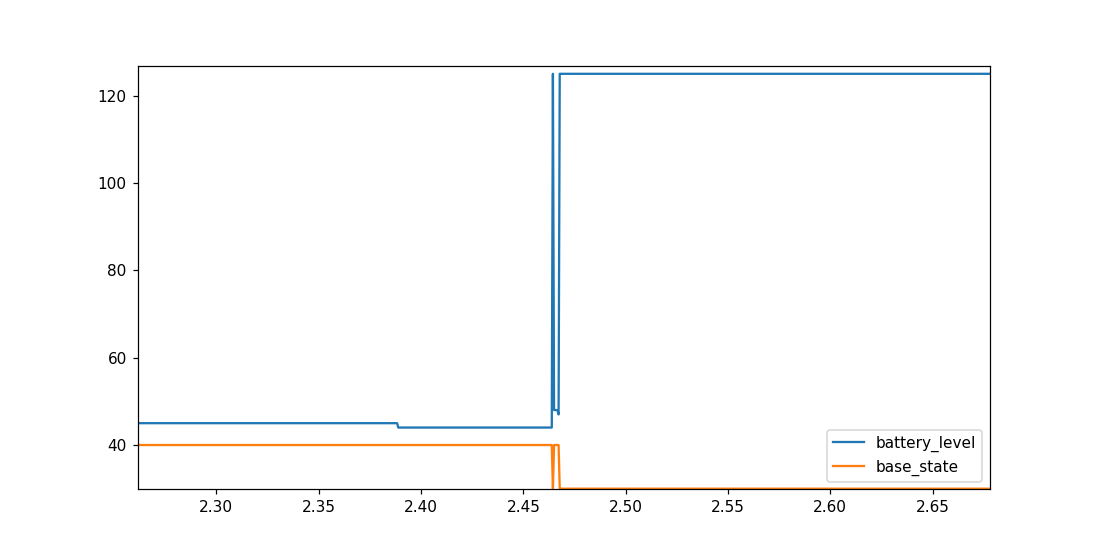

In [983]:
df_plot = df_test[['battery_level', 'base_state']]
df_plot.base_state = df_plot.base_state.apply(lambda x: x*10)

x = (np.array(list(df_plot.index)) * 2)/60/60
plt.plot(x,df_plot.battery_level)
plt.plot(x,df_plot.base_state)
plt.legend(loc='lower right')
plt.show()

In [955]:
df_battery = df_test.loc[df_test.base_state != 3][['dsn','timestamp','battery_level']]
df_battery['time_diff'] = df_battery.timestamp.diff()

In [772]:
times = list(df_battery[df_battery.time_diff > pd.Timedelta(minutes=10)].timestamp.values) + [list(df_battery.timestamp.values)[-1]]
# Need to include last timestamp

In [773]:
print(times)

[numpy.datetime64('2017-06-10T13:36:59.000000000')]


In [958]:
time, d = non_charging_time(df_test)

In [959]:
battery_lost_per_hr(time,d)

-0.41087551993507154

In [980]:
d[d.timestamp > '2017-12-13 4:22:58']#[d.time_diff > pd.Timedelta(seconds=2)]

,index,timestamp,battery_level,time_diff
7885,7885,2017-12-13 04:23:00,4,00:00:02
7886,7886,2017-12-13 04:23:02,4,00:00:02
7887,7887,2017-12-13 04:23:04,4,00:00:02
7888,7888,2017-12-13 04:23:06,4,00:00:02
7889,7889,2017-12-13 04:23:08,4,00:00:02
7890,7890,2017-12-13 04:23:10,4,00:00:02
7891,7891,2017-12-13 04:23:12,4,00:00:02
7892,7892,2017-12-13 04:23:14,4,00:00:02
7893,7893,2017-12-13 04:23:16,4,00:00:02
7894,7894,2017-12-13 04:23:18,4,00:00:02


In [852]:
# longest_consecutive(df_battery)

In [853]:
# df_test.iloc[3480:3500][['timestamp','battery_level']]

### How many times were "fail" devices stored with low battery

In [ ]:
def count_degraded_battery(dsn, gap_size, folder_dsns, thresh=95):
    count = 0
    rows = []
    folder_2sec = find_folder(dsn, folder_dsns)
    filepaths = glob(f'/Volumes/baileyWD/TwoSecondSockMask{folder_2sec}/{dsn}/*.csv.gz')
    all_dates = sorted([date(int(day[-15:-11]), int(day[-11:-9]), int(day[-9:-7])) for day in filepaths])
    # turn into series? or can i do diff
    diff = np.diff(all_dates) # Take into account gaps that naturally exist like Feb 2019 - Apr 2019..
    gap_mask = np.append((diff >= gap_size),np.array(False))
    
    days_before_large_gap = list(np.array(all_dates)[gap_mask])
    
    if len(days_before_large_gap) == 0:
        return rows
    else:
        # load 2 second data for days_before_large_gap and check last battery level
        for day in days_before_large_gap:
            day = str(day).replace('-', '')
            df = pd.read_csv(f'/Volumes/baileyWD/TwoSecondSockMask{folder_2sec}/{dsn}/{dsn}_{day}.csv.gz', compression='gzip', names=column_names)
            df = clean_df(df)
            if df.shape[0] != 0:
                # what is the battery level for the last reading\
                battery_level = df[df.timestamp == df.timestamp.max()].battery_level.values[0]
#                 if battery_level < thresh:
#                     # Try counting instead of returning True
#                     count += 1
                rows.append((dsn, day, battery_level))
    
    return rows

In [ ]:
df_2 = pickle.load(open('first_half_df_2.p','rb'))
df_2nd_half = pickle.load(open('second_half_df_2.p','rb'))
df_2 = df_2.append(df_2nd_half, ignore_index=True)
df_2 = df_2.drop_duplicates()
df_2 = df_2.loc[df_2.battery_lost_per_hr > 0]

# failed_devices = set(df_2.loc[df_2.lasts_8_hrs == 'fail'].dsn.values)
folder_dsns = pickle.load(open('folder_dsns.p','rb'))
# dsn_times_degrade = dict()
all_rows = []
for dsn in tqdm_notebook(v2_round2):
    # may need to use updated v2 device dates for this to be accurate
#     dsn_times_degrade[dsn] = count_degraded_battery(dsn, timedelta(days=3), folder_dsns, thresh=80)
    all_rows += count_degraded_battery(dsn, timedelta(days=46), folder_dsns, thresh=80)
    
col = ['dsn', 'day', 'battery_level']    
df_degrade = pd.DataFrame(all_rows, columns=col)

In [ ]:
degrade_2 = pickle.load(open('battery_2day_gap.p','rb'))
degrade_24 = pickle.load(open('battery_24day_gap.p','rb'))
degrade_45 = pickle.load(open('battery_45day_gap.p','rb'))
degrade_60 = pickle.load(open('battery_60day_gap.p','rb'))

### Get an idea of how many devices should have more than 365 days of monitoring

In [313]:
folder = '16k_round_2'
num_days_used = []
for dsn in tqdm_notebook(v2_round2):
    became_v2 = v2_updated_at.loc[v2_updated_at.dsn == dsn].updated_at.values[0]
    ten_min = pickle.load(open(f'/Volumes/baileyWD/{folder}/16000_dfs/{dsn}_df.p', 'rb')).drop_duplicates()
    ten_min = ten_min.loc[ten_min.index >= became_v2]
    
    unique_days = list(ten_min.index.normalize().unique())
    num_days_used.append(len(unique_days))

In [314]:
pickle.dump(num_days_used, open('round_2_days_used.p','wb'))

# Findings

Stats on the results

In [ ]:
# get accurate # of devices since there could be many for 1 dsn
# df.groupby(["dsn", "sock_number"]).size()

In [916]:
total_v2 = df_2.dsn.value_counts().shape[0]
one_fail = df_2.loc[df_2.lasts_8_hrs == 'fail'].dsn.value_counts().shape[0]
last_day = df_2.sort_values(by=['dsn','date']).drop_duplicates('dsn',keep='last')
last_fail = last_day.query("lasts_8_hrs == 'fail'").dsn.value_counts().shape[0]

first_day = df_2.sort_values(by=['dsn','date']).drop_duplicates('dsn',keep='first')
first_fail = first_day.query("lasts_8_hrs == 'fail'").dsn.value_counts().shape[0]

year_of_use = df_2.loc[df_2.time_since_first_use >= pd.Timedelta(days=365)].dsn.value_counts().shape[0]
year_use_fail = last_day.loc[(last_day.time_since_first_use >= pd.Timedelta(days=365)) & 
                             (last_day.lasts_8_hrs == 'fail')].dsn.value_counts().shape[0]

print(f'Total V2 devices analyzed: {total_v2:,}')
print(f'Devices with at least 1 instance of %battery loss > 12.5: {one_fail}')
print(f'Devices with the first day of use with %battery loss > 12.5: {first_fail}')
print(f'Devices with the last day of use with %battery loss > 12.5: {last_fail}')
print(f'Devices with use >= 365 days after first use: {year_of_use}')
print(f'Devices with use >= 365 days after first use and last day having %battery loss > 12.5: {year_use_fail}')


Total V2 devices analyzed: 12,287
Devices with at least 1 instance of %battery loss > 12.5: 734
Devices with the first day of use with %battery loss > 12.5: 98
Devices with the last day of use with %battery loss > 12.5: 42
Devices with use >= 365 days after first use: 1153
Devices with use >= 365 days after first use and last day having %battery loss > 12.5: 5


In [920]:
count = 0
day_of_use = []
dsns_fail_end = []
dsns_one_fail = list(set(df_2.loc[df_2.lasts_8_hrs == 'fail'].dsn.values))
# df_2.query('dsn in @dsns_one_fail').sort_values(by=['dsn','date'])
for dsn in tqdm_notebook(dsns_one_fail):
    df_dsn = df_2.loc[df_2.dsn == dsn].sort_values(by=['dsn','date'])
    last_5 = df_dsn.iloc[-5:]
    if last_5.loc[last_5.lasts_8_hrs == 'fail'].shape[0] > 0:
        dsns_fail_end.append(dsn)
        day_of_use.append(last_5.time_since_first_use.values)
        count += 1

In [921]:
print(f'Devices with %battery loss > 12.5 in the last 5 days of use: {count}')

Devices with %battery loss > 12.5 in the last 5 days of use: 112


Battery stats for devices that failed

In [741]:
def dead_batteries(dsn_list, v2_updated_at):
    dictionary = dict()
    for dsn in tqdm_notebook(dsn_list):
        became_v2 = v2_updated_at.loc[v2_updated_at.dsn == dsn].updated_at.values[0]
        df_all= pickle.load(open(f'/Volumes/baileyWD/16k_round_2/16000_dfs/{dsn}_df.p', 'rb')).drop_duplicates()
        df_all = df_all.loc[df_all.index >= became_v2]
        
        num_dead_battery = df_all.query("battery_level_min == 0").battery_level_min.count()
        dictionary[dsn] = num_dead_battery
        
    avg = sum(dictionary.values())/len(dsn_list)
    std = np.std(list(dictionary.values()))
    return dictionary, avg, std

# May want to do this for failed & not failed to see if there is a difference (get avg/std of both)

last_failed_devices = set(last_day.loc[last_day.lasts_8_hrs == 'fail'].dsn.values)
last_fail_low_battery, avg_last, std_last = dead_batteries(last_failed_devices, v2_updated_at)

failed_devices = set(df_2.loc[df_2.lasts_8_hrs == 'fail'].dsn.values)
fail_low_battery, avg_fail, std_fail = dead_batteries(failed_devices, v2_updated_at)
    
pass_devices = set(df_2.loc[df_2.lasts_8_hrs == 'pass'].dsn.values)
pass_low_battery, avg_pass, std_pass = dead_batteries(pass_devices, v2_updated_at)

In [748]:
print(f'Dead Batteries for devices that never failed. Average: {avg_pass:,.2f}, Std Dev: {std_pass:,.2f}')
print(f'Dead Batteries for devices that failed at least once. Average: {avg_fail:,.2f}, Std Dev: {std_fail:,.2f}')
print(f'Dead Batteries for devices failed during last use. Average: {avg_last:,.2f}, Std Dev: {std_last:,.2f}')

Dead Batteries for devices that never failed. Average: 6.03, Std Dev: 10.94
Dead Batteries for devices that failed at least once. Average: 11.59, Std Dev: 19.86
Dead Batteries for devices failed during last use. Average: 7.14, Std Dev: 8.84


In [752]:
#max and min for each
print(f'Failed max: {max(list(fail_low_battery.values()))}, Failed min: {min(list(fail_low_battery.values()))}')
print(f'Passed max: {max(list(pass_low_battery.values()))}, Passed min: {min(list(pass_low_battery.values()))}')

Failed max: 257, Failed min: 0
Passed max: 257, Passed min: 0


In [ ]:
# Number of times the device was stored for >= 2 days with battery <= 80%
# dsn_times_degrade = dict()
# for dsn in tqdm_notebook(failed_devices):
#     # may need to use updated v2 device dates for this to be accurate
#     dsn_times_degrade[dsn] = count_degraded_battery(dsn, timedelta(days=3), folder_dsns, thresh=80)

Average % of battery lost per hour over time

In [65]:
# socks = df_2.dsn.value_counts().shape[0]#df_2.groupby(["dsn", "sock_number"]).size().shape[0]
socks = normal_use.dsn.value_counts().shape[0]

In [63]:
# rolling = df_2[['time_since_first_use','battery_lost_per_hr']]
rolling = normal_use[['time_since_first_use','battery_lost_per_hr']]
# rolling.time_since_first_use = rolling.time_since_first_use.apply(lambda x: x.days)
rolling.time_since_first_use = rolling.time_since_first_use.apply(lambda x: (x.days//5) * 5)

/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


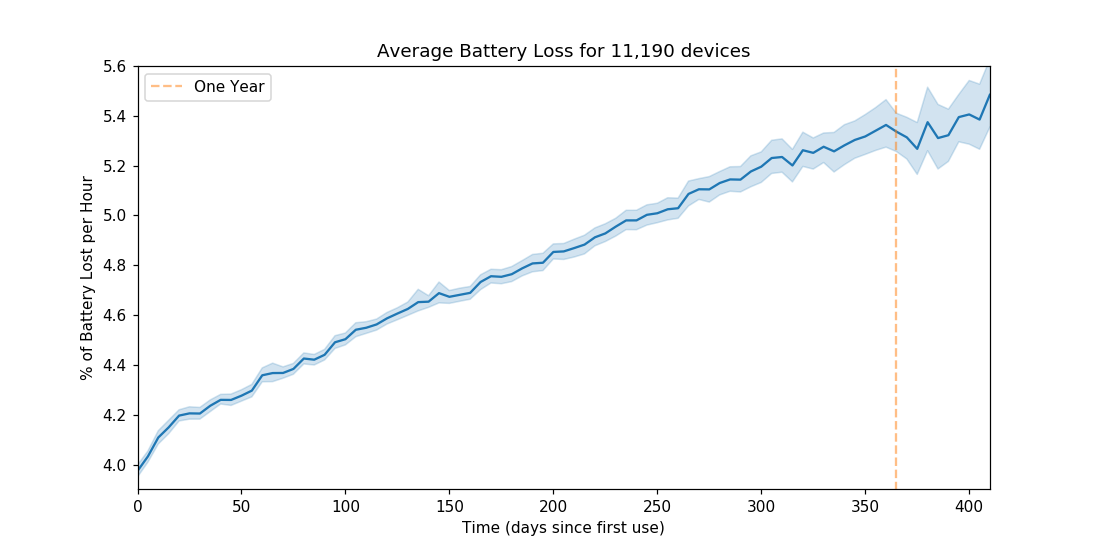

In [68]:
sns.lineplot(x='time_since_first_use', y='battery_lost_per_hr',data=rolling,ci=98)#df_2[['time_since_first_use','battery_lost_per_hr']]
plt.plot([365]*20,np.linspace(0,13,20), '--',alpha=.5, label='One Year')
# plt.plot(np.linspace(0,410,410), [12.5]*410,'--',color='tab:red',alpha=.5, label='8 hr limit')
# plt.ylim((4,13))
plt.xlim(0,410)
plt.ylim((3.9,5.6))
plt.xlabel("Time (days since first use)")
plt.ylabel("% of Battery Lost per Hour")
plt.title(f"Average Battery Loss for {socks:,} devices")
plt.legend(loc='best')
plt.show()
# TODO Try with a line that shows where it would be if it lasts exactly 8 hours?

# ci = 'sd' standard deviation, does this change anything? or if I put *98* will it do 98%**

In [673]:
# devices = df_2.dsn.value_counts().shape[0]
# df_2.sort_values(by='time_since_first_use').groupby('time_since_first_use').mean().reset_index(drop=True).battery_lost_per_hr.rolling(window=5).mean().plot()#.plot(x='date',y='battery_lost_per_hr')
# plt.xlabel("Time (days since first use)")
# plt.ylabel("% of Battery Lost per Hour")
# plt.title(f"Average Battery Loss for {devices:,} devices")
#TODO vertical line at 1 year, make note of how long this means that the batteries will last; 
#May also need too note how many devices are actually still being used at that point (a lot less than 10,000...)


In [674]:
# df_2.sort_values(by='time_since_first_use').groupby('time_since_first_use').mean().reset_index(drop=True).battery_lost_per_hr.plot()

% of devices that get at least 8 hours of use

In [1024]:
# plot = df_2.query('dsn in @not_degraded')#.copy()
# plot.lasts_8_hrs = plot.lasts_8_hrs.apply(lambda x: 1 if (x == 'pass') else 0)
# plot.time_since_first_use = plot.time_since_first_use.apply(lambda x: x.days)
# days_last_8_hrs = plot[['time_since_first_use','lasts_8_hrs']].groupby('time_since_first_use').sum()
# days_last_8_hrs['total'] = plot[['time_since_first_use','lasts_8_hrs']].groupby('time_since_first_use').count().lasts_8_hrs
# days_last_8_hrs['percent'] = (days_last_8_hrs.lasts_8_hrs / days_last_8_hrs.total) * 100
# TODO SHOULD THIS BE A CUMULATIVE SUM OF THE DEVICES THAT FAILED WITHIN THE TIME? 
    # at 6 months how many have had a fail, at 9 months, at 12 months


In [675]:
# days_last_8_hrs.plot(y='percent')
# plt.xlabel("Time Since First Use (days)")
# plt.ylabel("% of Devices")
# plt.title(f"Percentage of Devices that Last at Least 8 Hours({devices:,} devices)")

In [592]:
#make separate plot
# days_last_8_hrs.plot(y='total')

# include on same plot
# plt.scatter(days_last_8_hrs.index,days_last_8_hrs.total/50,alpha=.5,s=2)
# plt.ylim((0,105))
# plt.legend(loc='lower right')

% of devices that have never failed over time

In [299]:
# no_fail = v2_round2 - set(df_2[df_2.lasts_8_hrs == 'fail'].dsn.unique().tolist())
# for any day I want to know count on that day and count of how many devices have never failed up to that point
# def f(x):
#     day_dsns = set(df_2.loc[(df_2.time_since_first_use == x['time_since_first_use']) & (df_2.battery_lost_per_hr > 0)].dsn.values)
#     dsns_data = df_2.query('dsn in @day_dsns')
#     fail = dsns_data.loc[dsns_data.lasts_8_hrs == 'fail']
#     if fail.shape[0] == 0:
#         return 0
#     else:
#         return fail.dsn.value_counts().shape[0] / len(day_dsns)

# percent_no_fail = df_2[['time_since_first_use','lasts_8_hrs']].groupby('time_since_first_use').count()
# percent_no_fail = percent_no_fail.reset_index()
# percent_no_fail['fail_percent'] = percent_no_fail.apply(f,axis=1)
# # percent_no_fail['percent'] = percent_no_fail['fail']/percent_no_fail['lasts_8_hrs'] # Inaccurate
# percent_no_fail['percent'] =100-(percent_no_fail['fail_percent']*100)
# percent_no_fail.time_since_first_use = percent_no_fail.time_since_first_use.apply(lambda x: x.days)

In [676]:
# percent_no_fail.plot(x='time_since_first_use',y='percent',legend=None) # x axis is only correct if it matches time_since_first_use_column
# plt.xlabel("Time Since First Use (days)")
# plt.ylabel("Percent of Devices ")
# plt.title(f"Percentage of Devices that Always Lasted 8 hours ({devices:,} devices) ")

In [ ]:
# Perhaps take out instant_fail dsns then look for other instant fails?

In [71]:
def get_fail(x):
#     this_day = df_2.query('dsn not in @fail_instant2').loc[(df_2.time_since_first_use == x['time_since_first_use'])].dsn.unique().tolist()
#     fails = len(df_2.query('dsn in @this_day and lasts_8_hrs == "fail"').dsn.unique().tolist())
    this_day = normal_use.query('dsn not in @fail_instant2').loc[(normal_use.time_since_first_use == x['time_since_first_use'])].dsn.unique().tolist()
    fails = len(normal_use.query('dsn in @this_day and lasts_8_hrs == "fail"').dsn.unique().tolist())
    return 100*(fails/len(this_day))


In [72]:
# each day, how many devices are being used at that point; how many *of those devices* have failed up to that point
# days_df = df_2.query('dsn not in @fail_instant2').time_since_first_use.value_counts().reset_index()
days_df = normal_use.query('dsn not in @fail_instant2').time_since_first_use.value_counts().reset_index()
days_df.columns = ['time_since_first_use','num_devices']
days_df['fail_percent'] = days_df.apply(get_fail,axis=1)
days_df['pass_percent'] = 100-days_df.fail_percent
days_df.time_since_first_use = days_df.time_since_first_use.apply(lambda x: x.days)
days_df = days_df.sort_values(by='time_since_first_use')
# TODO try with rolling
# days_df.time_since_first_use = days_df.time_since_first_use.apply(lambda x: (x//5) * 5) #[looks super funny need more days]

<IPython.core.display.Javascript object>


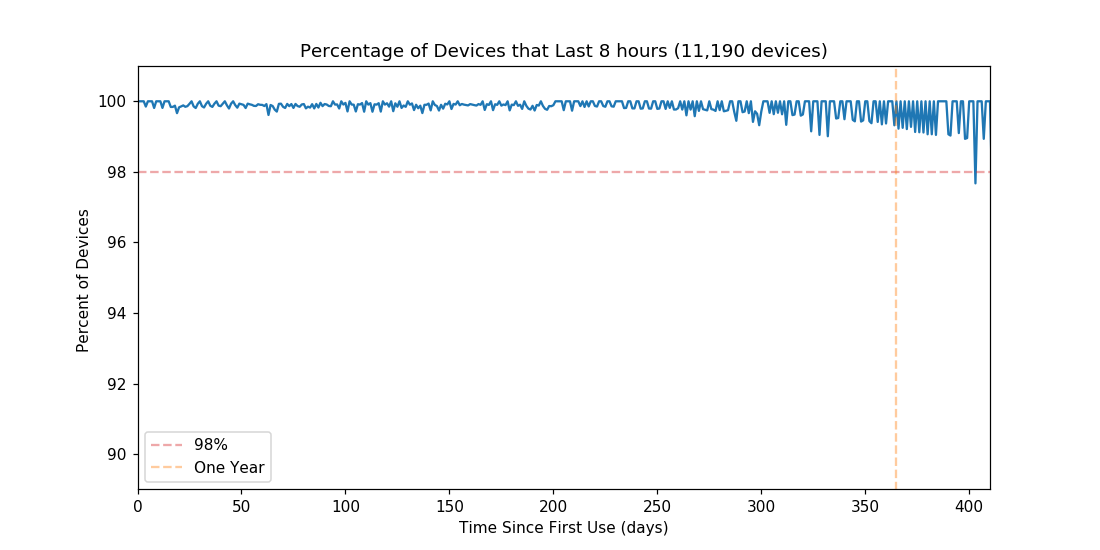

In [73]:
# devices_no_instant_fail = df_2.query('dsn not in @fail_instant2').dsn.value_counts().shape[0]
devices_no_instant_fail = normal_use.query('dsn not in @fail_instant2').dsn.value_counts().shape[0]
plt.plot(days_df['time_since_first_use'].values,days_df['pass_percent'].values)
plt.plot(np.linspace(0,410,411),[98]*411, '--',color='tab:red',alpha=.4, label='98%')#eliminate completly?
plt.plot([365]*100,np.linspace(0,104,100), '--',color='tab:orange',alpha=.4, label='One Year')
plt.xlim(0,410)
plt.ylim((89,101))
plt.xlabel("Time Since First Use (days)")
plt.ylabel("Percent of Devices ")
plt.title(f"Percentage of Devices that Last 8 hours ({socks:,} devices)")#excludes marginal pass
plt.legend(loc='best')
#TODO if we exclude 'marginal pass', we need to extend those that fail 
# (meaning if it fails before a year it will also fail anytime after that, 
# show this in the results even if they are no longer using the device for that long)
# can I project with each device?

<IPython.core.display.Javascript object>


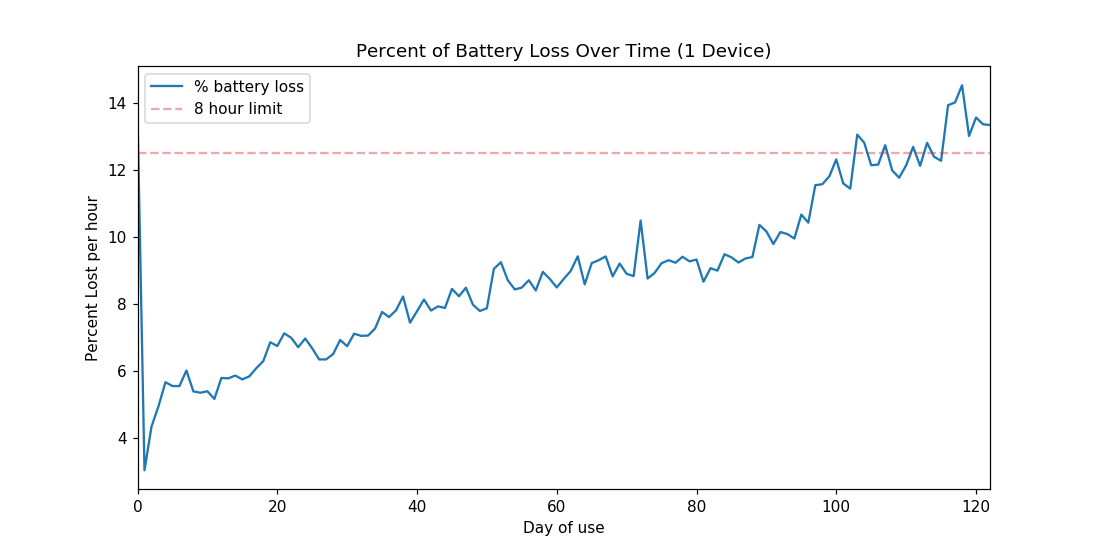

In [918]:
df_2[(df_2.dsn == 'AC000W001181968_1') & (df_2.sock_number == 1)].sort_values(by='date').reset_index(drop=True).battery_lost_per_hr.plot(label='% battery loss')
plt.plot(np.linspace(0,410,411),[12.5]*411, '--',color='tab:red',alpha=.4, label='8 hour limit')#different color? or eliminate completly?
plt.xlabel("Day of use")
plt.ylabel("Percent Lost per hour")
plt.title(f"Percent of Battery Loss Over Time (1 Device)")
plt.legend(loc='best')

In [577]:
# month1 = df_2.loc[(df_2.time_since_first_use <= 31) & (df_2.battery_lost_per_hr > 0)]

In [626]:
# print(100-((month1[month1.lasts_8_hrs == 0].dsn.value_counts().shape[0]/month1.dsn.value_counts().shape[0])*100))